# **Shot type classification: VGG16 Transfer learning**

### In this notebook, a classification task of the different types of cinematographic shots has been implemented. This approach exploits the transfer learning technique to perform a classification of the types of shots present:
*   ### Close-up
*   ### Medium close-up
*   ### Medium shot
*   ### Medium wide
*   ### Wide shot

### Transfer learning is a technique that leverages the knowledge learned from pre-trained models on a large dataset to solve a different but related problem. For this approach, in order to perform a shot type classification, transfer learning with VGG16 has been implemented utilizing the pre-trained weights of the VGG16 model that were trained on a large dataset like ImageNet.

# **0. Google Colab Setup and Global Constants Definition**

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "<path>"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "<path>"
GDRIVE_DATA_CSV = GDRIVE_HOME_DIR + "<path>"

RANDOM_SEED = 42 # for reproducibility

# Point Colaboratory to our Google Drive
from google.colab import drive
drive.mount(GDRIVE_DIR, force_remount=True)

import os
os.environ["JAVA_HOME"] = JAVA_HOME

Mounted at /content/drive


In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import cv2 as cv
import PIL.Image as Image
import io
import numpy as np

# **1. Shot type classification**

## **1.1** Loading the shot type dataset into a pandas dataframe

In [ ]:
url = GDRIVE_HOME_DIR + "/Big_Data/shot_type/binaryData.parquet"
pandas_df = pd.read_parquet(url)

## **1.2** Data Preprocessing

### For this approach we decided to use two different types of preprocessing to apply to the images:

### **1.   Rgb**
### **2.   Adaptive Thresholding**: It is a technique used in image processing to separate foreground objects from the background based on local pixel intensities. The image is divided into small overlapping regions, called blocks, and for each block, a threshold value is calculated based on the method chosen (in our case Gaussian) and the block's pixel intensities.

### The chosen preprocessings are shown below
![picture](https://drive.google.com/uc?id=1K3nuHAnlNSNlftjOEEapR0mt0TyCGL21)

### Function that apply adaptive thresholding, normalization, and VGG16 preprocess_input funtion

In [ ]:
def adaptive_preprocessing(content):
    # Open binary image and resize it
    img = Image.open(io.BytesIO(content)).resize((224,244))

    # Convert RGB images in greyscale
    if img.mode == 'RGB':
      img = img.convert('L')

    # Apply adaptive threshold
    img = adap_threshold(img)

    # Convert the single-channel image to three channels
    img = np.stack((img,) * 3, axis=-1)

    # Convert the image to a NumPy array
    img = img_to_array(img) / 255.0

    return preprocess_input(img)


def adap_threshold(img):
  img = np.array(img)
  th3 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
  return th3

### Function that read the image in RGB format, apply normalization and VGG16 preprocess_input funtion

In [ ]:
def rgb_preprocessing(content):
    # Open binary image and resize it
    img = Image.open(io.BytesIO(content)).resize((224,224))

    # if there are graysclae images convert it to rgb
    if img.mode == 'L':
      img = img.convert('RGB')

    # Convert the image to a NumPy array
    img = img_to_array(img) / 255.0

    return preprocess_input(img)

### Apply preprocessing function

In [ ]:
# Apply preprocessing to content column
pandas_df["content"] = pandas_df.content.apply(lambda x : adaptive_preprocessing(x))

### Function to encoding shot type labels for the VGG16 model

In [ ]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def label_encoding(pandas_df):
  label_encoder = LabelEncoder()

  # Encode labels
  labels = label_encoder.fit_transform(pandas_df['shot_type'])

  y = to_categorical(labels)

  original_labels = label_encoder.inverse_transform(labels)

  # Create a dictionary with original labels and encoded labels
  label_dict = dict(zip(original_labels, labels))

  # Print the label dictionary
  print(label_dict)

  return y

### Convert data into a numpy array

In [ ]:
X = np.array(pandas_df['content'].tolist())
y = label_encoding(pandas_df)

In [ ]:
print(X.shape)
print(y.shape)

(7375, 244, 224, 3)
(7375, 5)


### Split data into Train, Val and Test sets

In [ ]:
# Split the data and labels into train and remaining data
X_train, remaining_data, y_train, remaining_labels = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

# Split the remaining data and labels into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(remaining_data, remaining_labels, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
print("Train Data Shape:", X_train.shape)
print("Train Labels Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Labels Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Labels Shape:", y_test.shape)

Train Data Shape: (5162, 244, 224, 3)
Train Labels Shape: (5162, 5)
Validation Data Shape: (1106, 244, 224, 3)
Validation Labels Shape: (1106, 5)
Test Data Shape: (1107, 244, 224, 3)
Test Labels Shape: (1107, 5)


### Save data numpy arrays for further usage

In [ ]:
np.save(GDRIVE_HOME_DIR + "/Big_Data/shot_type/TL/adp_thres_data/X_train.npy", X_train)
np.save(GDRIVE_HOME_DIR + "/Big_Data/shot_type/TL/adp_thres_data/y_train.npy", y_train)

np.save(GDRIVE_HOME_DIR + "/Big_Data/shot_type/TL/adp_thres_data/X_val.npy", X_val)
np.save(GDRIVE_HOME_DIR + "/Big_Data/shot_type/TL/adp_thres_data/y_val.npy", y_val)

np.save(GDRIVE_HOME_DIR + "/Big_Data/shot_type/TL/adp_thres_data/X_test.npy", X_test)
np.save(GDRIVE_HOME_DIR + "/Big_Data/shot_type/TL/adp_thres_data/y_test.npy", y_test)

## **1.3** Model Definition

### The following code defines a function called model_initialization that initializes transfer learning model based on the VGG16 architecture for the shot type classification task. Finally, the function also defines a further model with the task of classifying the images on the basis of what has been learned through the neural network. The model consists of the following layers:
*   ### The pre-trained VGG16 model (pre_trained_model).

*   ### A Flatten() layer to convert the output of the VGG16 model into a 1D feature vector.

*   ### Three fully connected (Dense) layers with 512, 256, and 5 units respectively. The activation function used for the first two layers is ReLU, and the last layer uses softmax activation for multi-class classification.

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [4]:
def model_initialization(non_trainable_layers):

  # Define image input shape
  image_width, image_height = 224, 224

  # VGG16 pre trained model definition
  pre_trained_model = VGG16(
      input_shape=(image_width,image_height,3),
      include_top=False,
      weights="imagenet"
  )

  # Freeze some convolution blocks
  for layer in pre_trained_model.layers[:non_trainable_layers]:
      layer.trainable = False

  print(pre_trained_model.summary())

  transfer_model = tf.keras.models.Sequential([
    pre_trained_model,

    Flatten(),
    Dense(512,activation='relu'),
    Dense(256,activation='relu'),
    Dense(5, activation='softmax')
  ])

  print(transfer_model.summary())

  return transfer_model

### Show model architecture

In [ ]:
model_initialization(17)

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## **1.4** Model Training


### Function that returns the data generator objects for data augmentation

In [5]:
def data_augmentation(batch_size, X_train, y_train, X_val, y_val):
  train_datagen = ImageDataGenerator(
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest'
  )
  train_generator = train_datagen.flow(
      X_train,
      y_train,
      batch_size=batch_size
  )

  val_datagen = ImageDataGenerator()
  val_generator = val_datagen.flow(
        X_val,
        y_val,
        batch_size=batch_size
  )

  return train_generator, val_generator

### Functions that perform the training of the model and save it

In [ ]:
def train_model(model, train_gen, val_gen, num_epochs, preprocess_name, non_trainable_layers):
  steps_per_epoch = train_gen.n // train_gen.batch_size
  val_steps = val_gen.n // val_gen.batch_size+1

  model.fit(
              train_gen,
              validation_data=val_gen,
              epochs=num_epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=val_steps
  )

  model_path = GDRIVE_HOME_DIR + '/Big_Data/shot_type/models/' + 'VGG16_' + preprocess_name + '_' + str(non_trainable_layers) + '_' + str(num_epochs) + 'epochs.h5'
  model.save(model_path)

## **1.5** Tuning Pipeline


### Function to load Train, Val, and Test sets based on preprocess_dir_name

In [6]:
def load_arrays(preprocess_dir_name):

  path = GDRIVE_HOME_DIR + '/Big_Data/shot_type/TL/' + preprocess_dir_name

  X_train = np.load(path + "/X_train.npy", allow_pickle=True)
  y_train = np.load(path + "/y_train.npy", allow_pickle=True)

  X_val = np.load(path + "/X_val.npy", allow_pickle=True)
  y_val = np.load(path + "/y_val.npy", allow_pickle=True)

  X_test = np.load(path + "/X_test.npy", allow_pickle=True)
  y_test = np.load(path + "/y_test.npy", allow_pickle=True)

  return X_train, y_train, X_val, y_val, X_test, y_test

### Function that describe the task pipeline:


1.   ###  Model initialization
2.   ###  Model compilation
3.   ###  Data augmentation
4.   ###  Model training

### The train_model function takes the model, training generator, validation generator, number of epochs, preprocessing name, and number of non-trainable layers as arguments. non-trainable-layers is one of the parameter tuned and it define the number of not trainable layers of the pre-trained VGG16. This approach strikes a balance between leveraging pre-trained knowledge and allowing the model to adapt to the shot type classification task. The second parameter tuned is the learning rate used for the Adam optimizer.





In [ ]:
def pipeline(X_train, y_train, X_val, y_val, non_trainable_layers, lr, batch_size, num_epochs, preprocess_name):
  model = model_initialization(non_trainable_layers)

  model.compile(
              loss="categorical_crossentropy",
              optimizer=Adam(learning_rate = lr),
              metrics=["accuracy"]
  )

  train_generator, val_generator = data_augmentation(batch_size, X_train, y_train, X_val, y_val)

  train_model(model, train_generator, val_generator, num_epochs, preprocess_name, non_trainable_layers)

### Start training sessions with different parameters and preprocessing

In [ ]:
preprocess_dir_name = "rgb_data"
X_train, y_train, X_val, y_val, X_test, y_test = load_arrays(preprocess_dir_name)
pipeline(X_train, y_train, X_val, y_val, 17, 1e-3, 32, 50, "rgb")
pipeline(X_train, y_train, X_val, y_val, 16, 1e-5, 32, 50, "rgb")

In [ ]:
preprocess_dir_name = "adp_thres_data"
X_train, y_train, X_val, y_val, X_test, y_test = load_arrays(preprocess_dir_name)
pipeline(X_train, y_train, X_val, y_val, 17, 1e-3, 32, 50, "adp_thres")
pipeline(X_train, y_train, X_val, y_val, 16, 1e-5, 32, 50, "adp_thres")

## **1.6** Evaluation

In [7]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Function to get the Test set generator for the evaluation phase

In [8]:
def get_test_generator(X_test, y_test):

  test_datagen = ImageDataGenerator()

  test_generator = test_datagen.flow(
    X_test,
    y_test,
    shuffle=False,
    batch_size=1
  )

  return test_generator

### Function to perform evaluation, it compute accuracy, F1 score and plot the confusion matrix. Due to a problem probably related to the network architecture, one of the trained models produced results that could not be analyzed, and was therefore excluded from this phase. The excluded model had the last three layers unfrozen and a learning rate of

In [9]:
from keras.utils import to_categorical

def get_model_metrics(model, X_test, y_test, model_name):

  test_gen = get_test_generator(X_test, y_test)

  predictions = model.predict(test_gen)

  predicted_labels = np.argmax(predictions, axis=1)

  predicted_labels_cat = keras.utils.to_categorical(predicted_labels)

  accuracy = accuracy_score(y_test, predicted_labels_cat)
  print("Accuracy:", accuracy)

  f1 = f1_score(y_test, predicted_labels_cat, average='weighted')
  print("F1 Score:", f1)


  # Calculate the confusion matrix
  confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), predicted_labels)

  # Display class names
  class_names = ['close-up', 'medium close-up', 'medium shot', 'medium wide', 'wide shot']

  # Convert the confusion matrix to integers
  confusion_mtx = confusion_mtx.astype('int')

  # Create a heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="d", cmap="Blues")
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(model_name)
  plt.show()

1107/1107 [==============================] - 17s 9ms/step
Accuracy: 0.5022583559168925
F1 Score: 0.5078547294537711


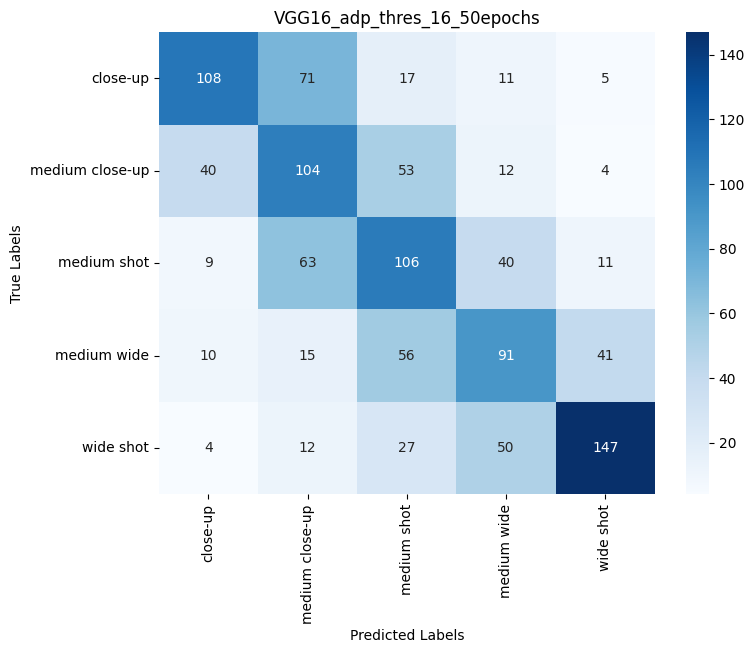

1107/1107 [==============================] - 10s 9ms/step
Accuracy: 0.5203252032520326
F1 Score: 0.5202001224695743


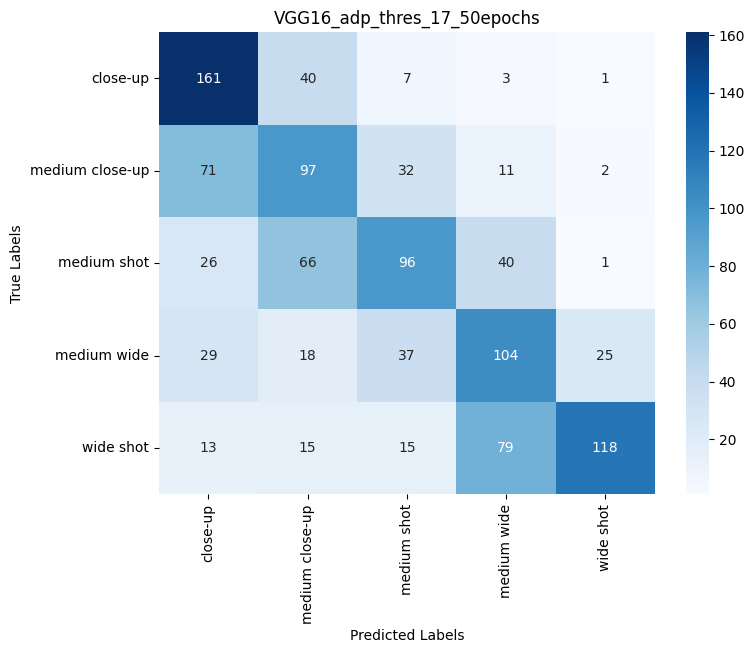

1107/1107 [==============================] - 10s 9ms/step
Accuracy: 0.37308039747064137
F1 Score: 0.3556033867261524


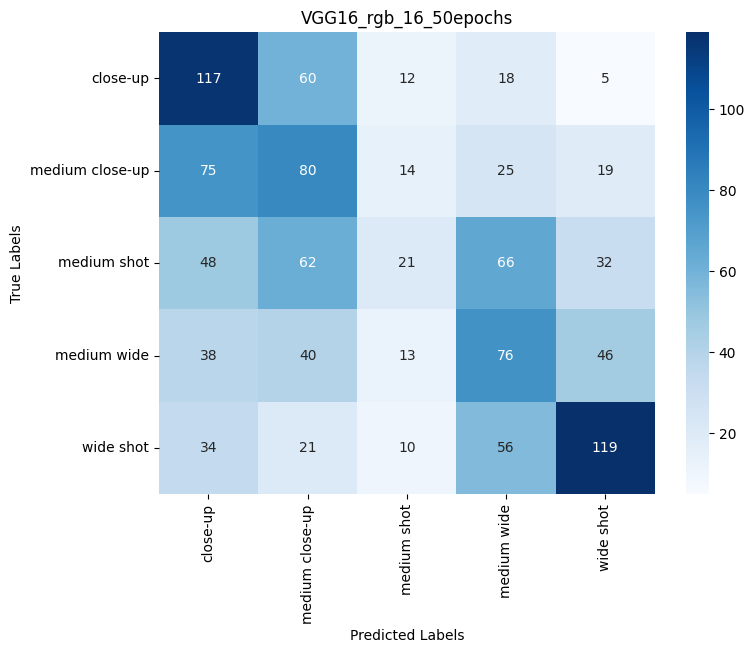

1107/1107 [==============================] - 10s 9ms/step


ValueError: ignored

In [10]:
for preprocess_dir_name in ["adp_thres_data", "rgb_data"]:
  models_list = [
      GDRIVE_HOME_DIR + '/Big_Data/shot_type/models/VGG16_' + preprocess_dir_name.replace('_data', '') + '_16_50epochs.h5',
      GDRIVE_HOME_DIR + '/Big_Data/shot_type/models/VGG16_' + preprocess_dir_name.replace('_data', '') + '_17_50epochs.h5',
  ]

  X_train, y_train, X_val, y_val, X_test, y_test = load_arrays(preprocess_dir_name)

  for model_path in models_list:

    model = keras.models.load_model(model_path)

    get_model_metrics(model, X_test, y_test, model_path.split('/')[-1].replace('.h5', ''))

  del X_train, y_train, X_val, y_val, X_test, y_test

## **1.7** Pipeline to test new samples on the trained models

In [ ]:
def prediction_sample(img_path, preprocessing_type, label):

  with open(img_path, 'rb') as file:
    img = file.read()

  # select the appropriate preprocessing mode and model
  match preprocessing_type:
    case "rgb":
      preprocessed_img = rgb_preprocessing(img)
      model = keras.models.load_model(GDRIVE_HOME_DIR + '/Big_Data/shot_type/models/VGG16_rgb_16_50epochs.h5')
      test_image = np.expand_dims(preprocessed_img, axis=0)

    case "adp_thres":
      preprocessed_img = adaptive_preprocessing(img)
      model = keras.models.load_model(GDRIVE_HOME_DIR + '/Big_Data/shot_type/models/VGG16_adp_thres_17_50epochs.h5')
      label_dict = {'close-up': 0, 'medium-close-up': 1, 'medium-shot': 2, 'medium-wide': 3, 'wide-shot': 4}

      label_index = label_dict[label]
      test_label = np.array([label_index])

      test_image = np.expand_dims(preprocessed_img, axis=0)

      test_label = np.zeros((1, 5))
      test_label[0, label_index] = 1

      test_image = get_test_generator(test_image, test_label)

  # get predictions array
  predictions = model.predict(test_image)

  return ['%.4f' % elem for elem in predictions[0]]


### Function to plot sample prediction scores

In [ ]:
def plot_image_with_scores(img_path, label, df, i):
    # Load the image
    image = Image.open(img_path).resize((320, 200))

    fig = plt.figure(figsize=(23, 5))

    # setting values to rows and column variables
    rows = 1
    columns = 2

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    plt.title(str(i) + '  ' + label)

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    table = plt.table(cellText=df.values, colLabels=df.columns, loc='center', bbox=[0, 0, 1, 0.7])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Adjust the values to center the table vertically
    plt.axis('off')

    plt.tight_layout()  # Ensures that the subplots and labels are properly centered
    plt.show()

1/1 [==============================] - 1s 809ms/step


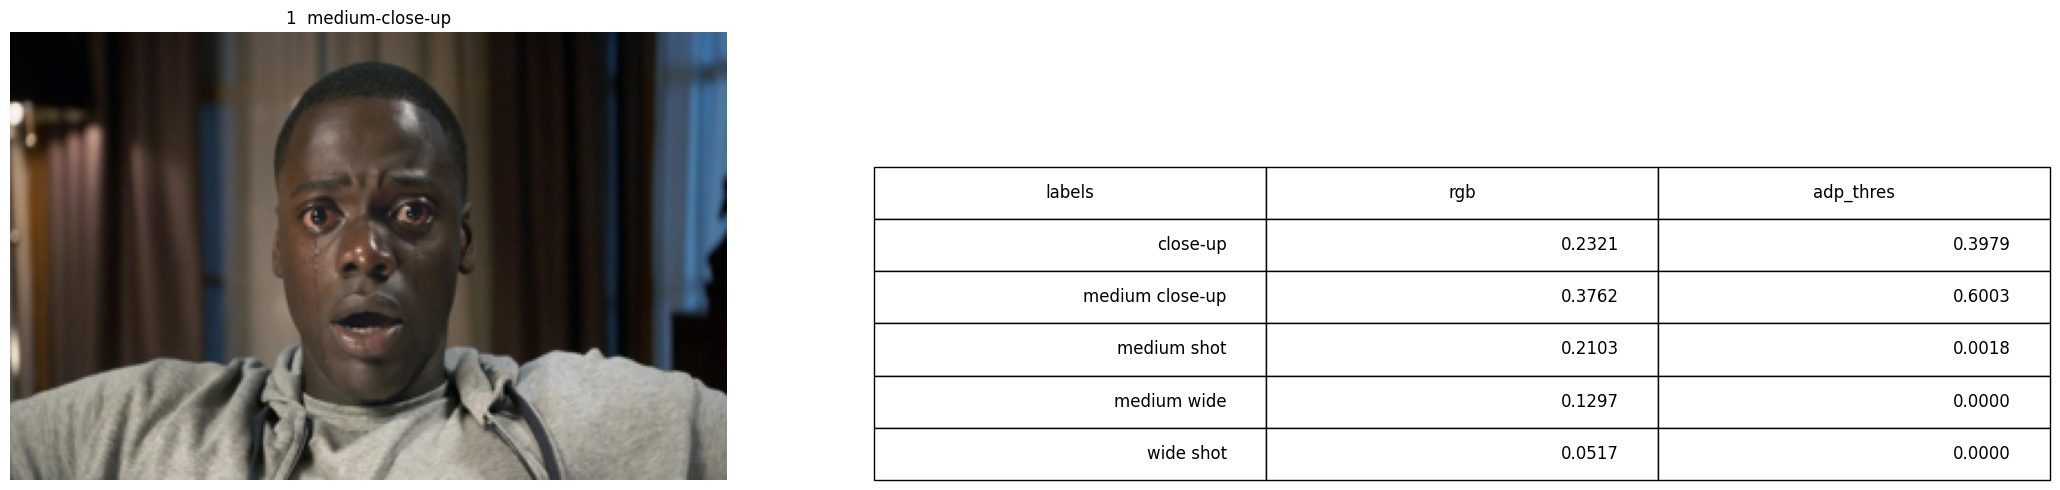

1/1 [==============================] - 0s 157ms/step


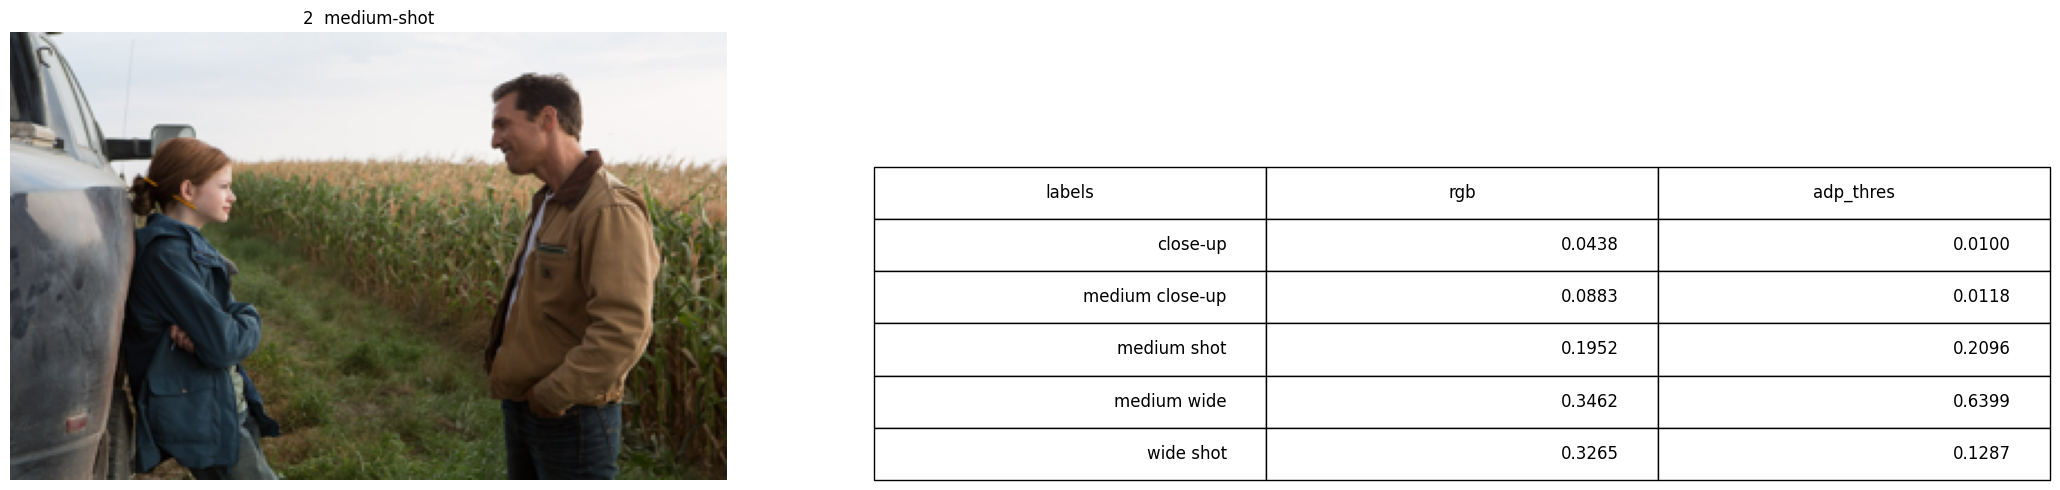

1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 164ms/step


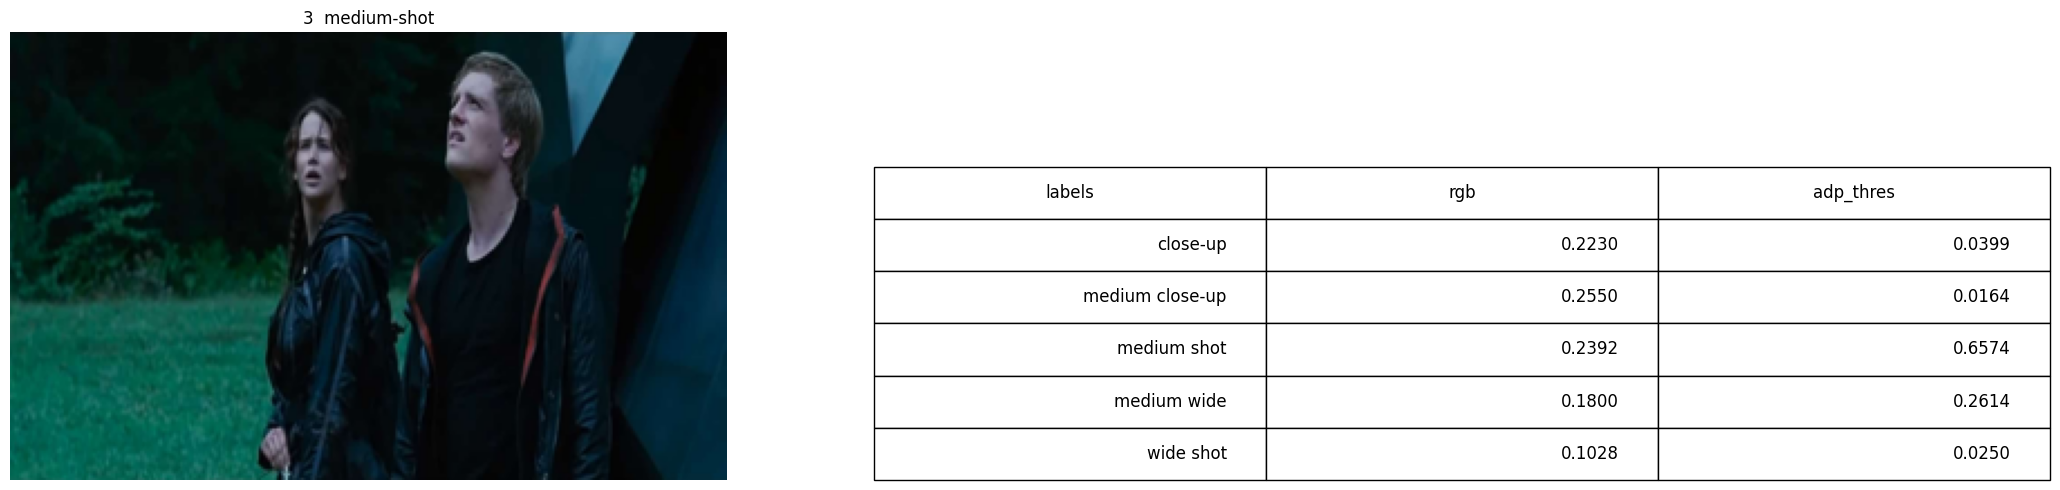

1/1 [==============================] - 0s 155ms/step


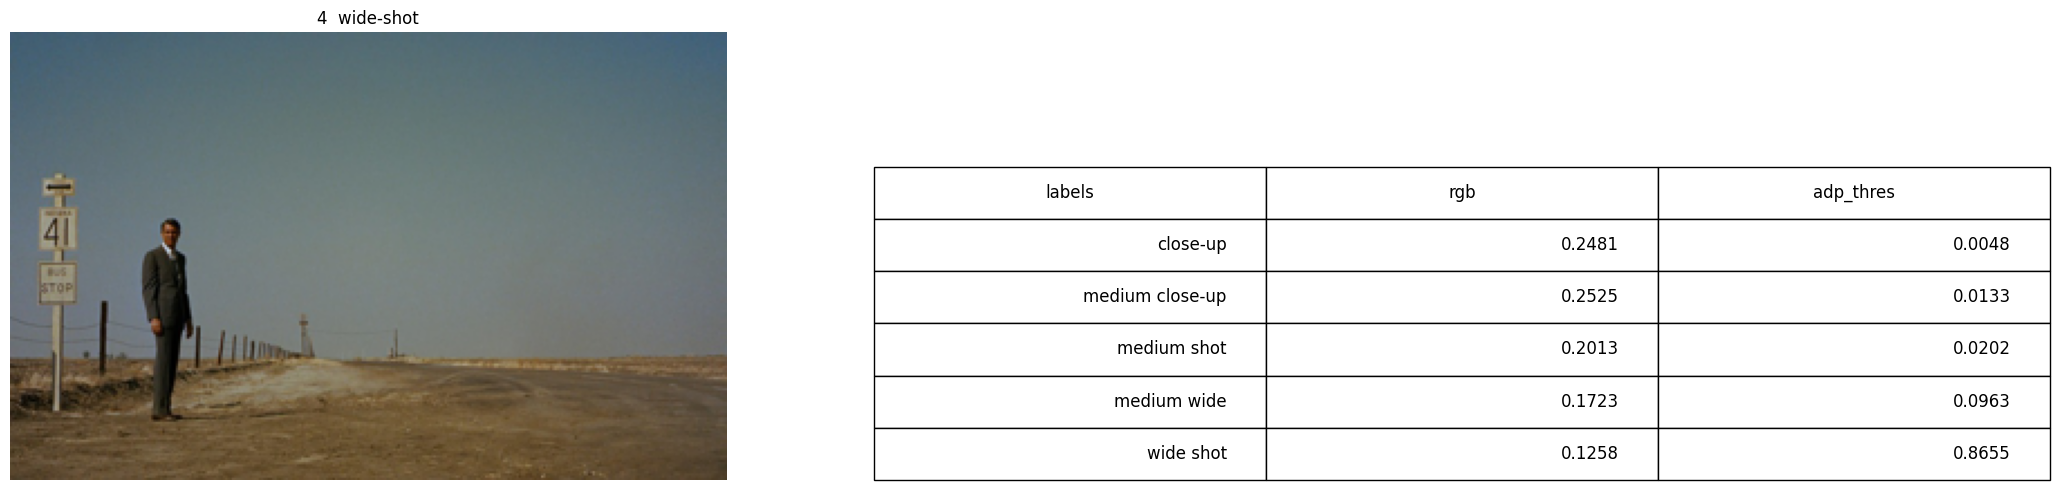

1/1 [==============================] - 0s 157ms/step


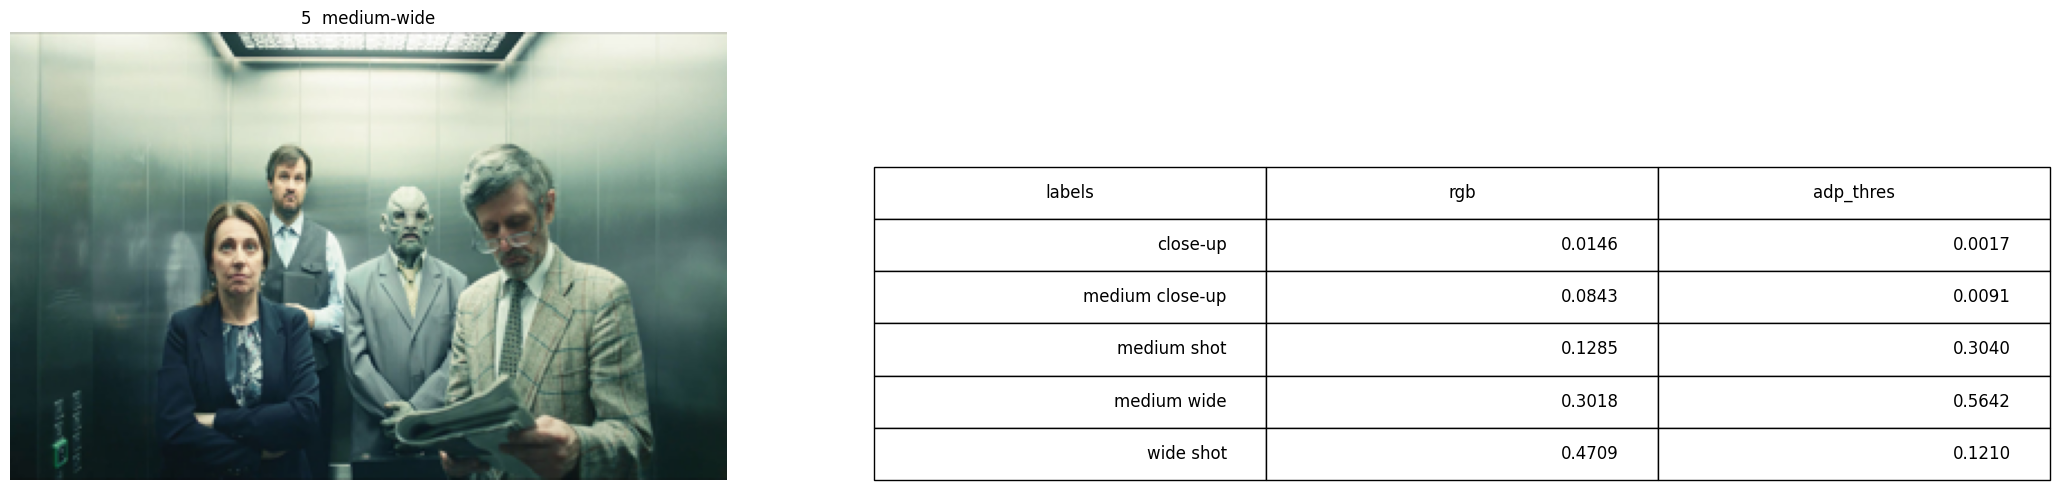

1/1 [==============================] - 0s 172ms/step


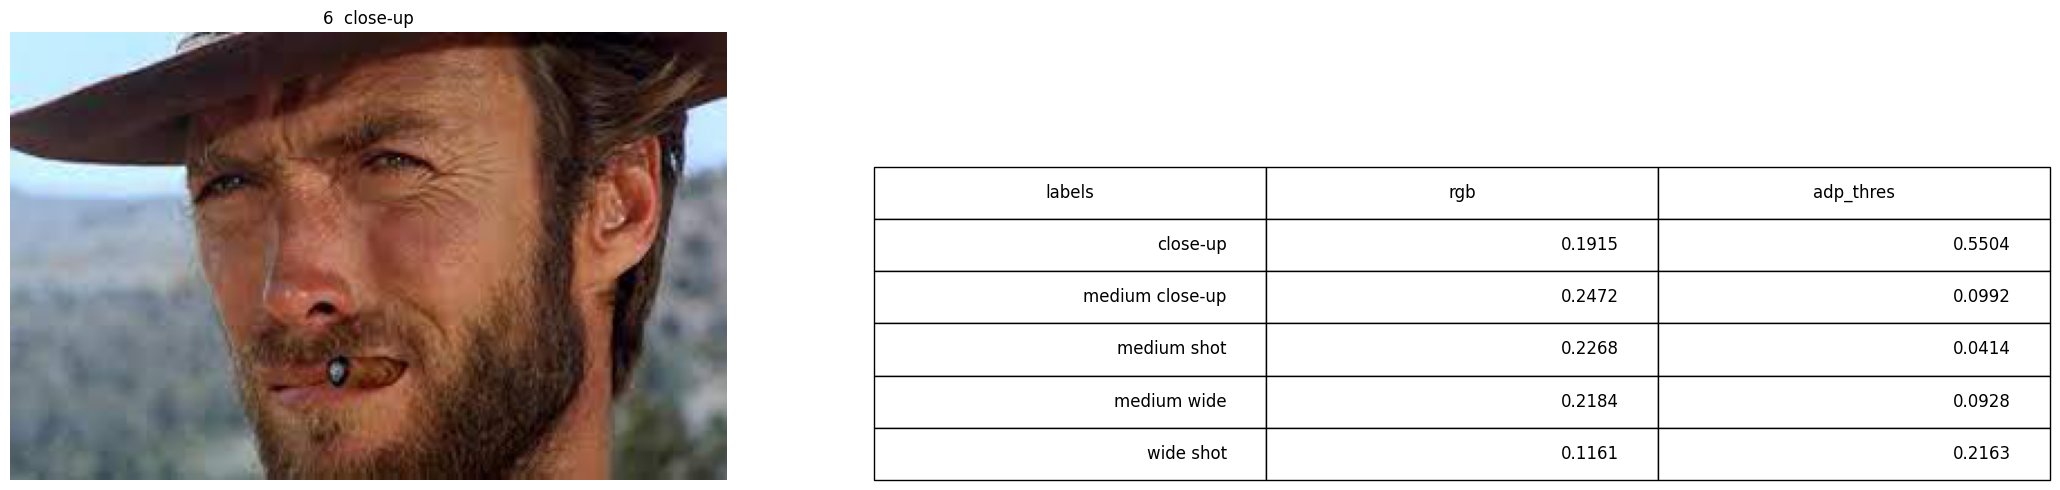

1/1 [==============================] - 0s 173ms/step


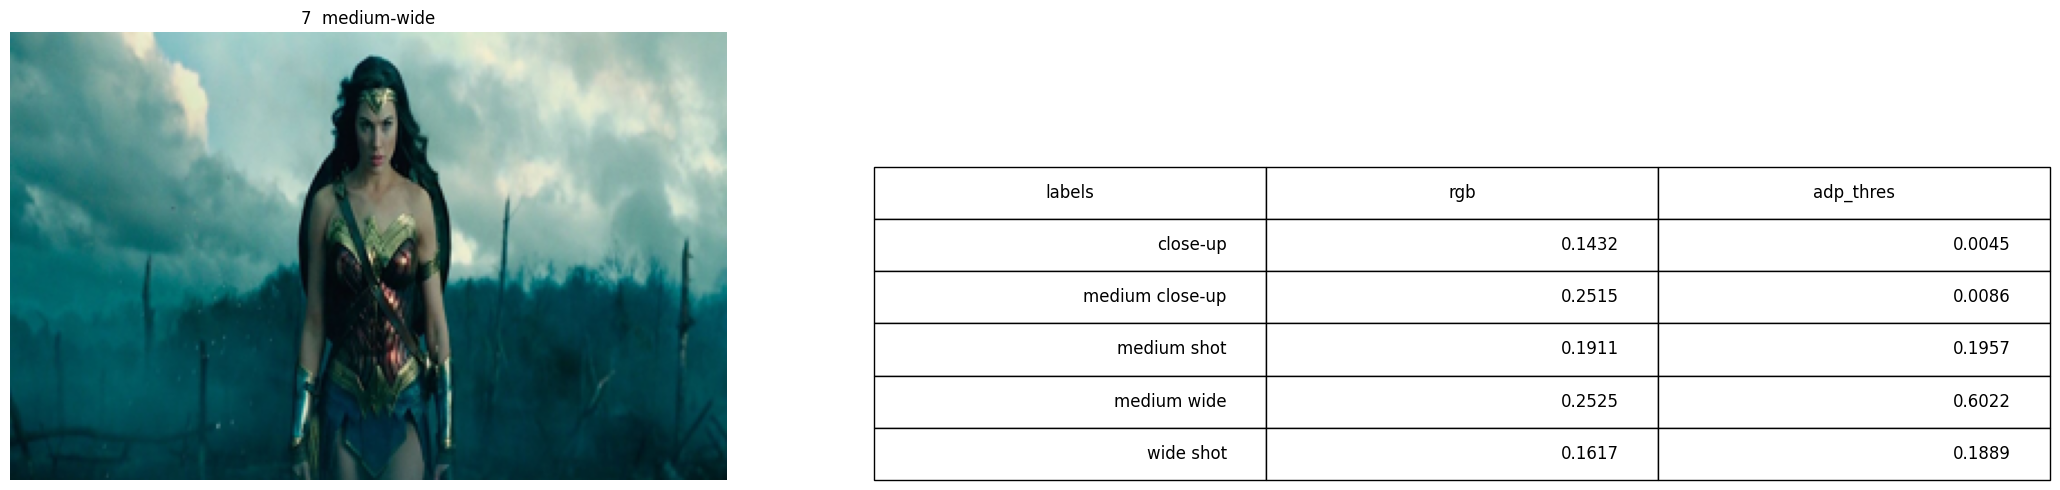

In [ ]:
import os

directory = "/content/drive/My Drive/Big_Data/shot_type/shot_type_samples/"

i = 1
for sample_path in os.listdir(directory):
  label = sample_path.split('/')[-1].split('_')[0]
  result_df = pd.DataFrame([], columns=['labels', 'rgb', 'adp_thres'])

  result_df['labels'] = ['close-up', 'medium close-up', 'medium shot', 'medium wide', 'wide shot']
  result_df['rgb'] = prediction_sample(os.path.join(directory, sample_path), "rgb", label)
  result_df['adp_thres'] = prediction_sample(os.path.join(directory, sample_path), "adp_thres", label)
  plot_image_with_scores(os.path.join(directory, sample_path), label, result_df, i)
  i+= 1

## **1.8** Conclusion

### Observing the results obtained from this approach, we note that none of the three proposed models offers optimal performance. The best is the one trained on preprocessed data through the adaptive thresholding technique and the freezing of the first 17 layers of the network, which offers an accuracy of 0.52. The decision to select these models is due to a series of tests and evaluations carried out by testing different classification networks, learning rates, data augmentations, and number of different epochs. Observing the tests performed on new samples (where only the best models for each preprocessing have been included), it can be seen that despite the non-optimal performances, the model based on adaptive thresholding returns the correct prediction except for sample number 2, the which, as specified in the conclusions of the second approach, represents a class with a high level of variability. We can find confirmation of this above all by observing the confusion matrix of the rgb-based model where the 'medium shot' class is practically never predicted correctly. In conclusion, the proposed models did not provide the expected results, which may be due to many aspects such as the large intra and inter class variability of our dataset, and the lack of experience of our group with regard to neural networks. However, it was interesting to observe how a neural network would perform considering a task like this.
### (The comparison of the approaches is reported in the second notebook on the classification of shot types.)